* Importação das bibliotecas necessárias:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score
)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")


# 1. Coletando e tratando os dados:

In [2]:
# Coletando dados da VALE3 e formatando o DataFrame:
vale = yf.download('VALE3.SA', start='2022-01-01', end='2025-06-01', multi_level_index=False)
vale = vale[['Close', 'Open', 'Volume']]
vale.reset_index(inplace=True)
vale['Date'] = pd.to_datetime(vale['Date'])
vale.set_index('Date', inplace=True)

# Criando um DataFrame para armazenar os dados do minério de ferro:
minerio_ferro = pd.read_csv(
    "Dados Históricos - Minério de ferro refinado 62% Fe CFR Futuros.csv"
    )
minerio_ferro.reset_index(inplace=True)
minerio_ferro['Data'] = pd.to_datetime(minerio_ferro['Data'], dayfirst=True)
minerio_ferro.set_index('Data', inplace=True)
minerio_ferro = minerio_ferro[['Último','Abertura', 'Var%']]
# invertendo a ordem das datas:
minerio_ferro = minerio_ferro.iloc[::-1]
minerio_ferro.rename(columns={
    'Último': 'Close',
    'Abertura': 'Open',
    'Var%': 'Variação'
}, inplace=True)

# Unindo os DataFrames de VALE3 e minério de ferro:
df = pd.merge(vale, minerio_ferro, left_index=True, right_index=True, suffixes=('_VALE3', '_Minerio'))
df.rename(columns={
    'Close_VALE3': 'Close_VALE3',
    'Open_VALE3': 'Open_VALE3',
    'Volume': 'Volume_VALE3',
    'Close_Minerio': 'Close_Minerio',
    'Open_Minerio': 'Open_Minerio',
    'Variação': 'Variação_Minerio'
}, inplace=True)

# Variação percentual do preço de fechamento da VALE3:
df['Variação_VALE3'] = df['Close_VALE3'].pct_change() * 100
# Trocando nan por 0%:
df['Variação_VALE3'].fillna(0, inplace=True)

# Vamos transformar as colunas Close_Minerio, Open_Minerio e Variação_Minerio em float:
df['Close_Minerio'] = df['Close_Minerio'].str.replace(',', '.', regex=False).astype(float)
df['Open_Minerio'] = df['Open_Minerio'].str.replace(',', '.', regex=False).astype(float)
df['Variação_Minerio'] = df['Variação_Minerio'].str.replace('%', '', regex=False).str.replace(',', '.', regex=False).astype(float)

# Variação percentual do preço de fechamento do minério de ferro:
df['Variação_Minerio'] = df['Close_Minerio'].pct_change() * 100 
# Trocando nan por 7,02%:
df['Variação_Minerio'].fillna(7.02, inplace=True)

df

[*********************100%***********************]  1 of 1 completed


,Close_VALE3,Open_VALE3,Volume_VALE3,Close_Minerio,Open_Minerio,Variação_Minerio,Variação_VALE3
2022-01-03,57.766407,58.507002,18557200,120.40,120.40,7.020000,0.000000
2022-01-04,57.085068,58.144119,18178700,120.91,120.91,0.423588,-1.179473
2022-01-05,57.625698,57.299840,22039000,124.14,124.14,2.671408,0.947061
2022-01-06,58.788429,58.240391,22044100,125.94,125.94,1.449976,2.017730
2022-01-07,62.209988,59.543846,35213100,126.21,126.21,0.214388,5.820122
...,...,...,...,...,...,...,...
2025-05-23,54.320000,54.000000,14747300,99.81,99.81,-0.080088,0.165960
2025-05-27,53.840000,54.000000,17943000,99.48,99.48,-0.330628,-0.883652
2025-05-28,53.410000,53.740002,17700600,99.39,99.39,-0.090470,-0.798663
2025-05-29,53.450001,53.730000,10246100,99.27,99.27,-0.120736,0.074894


# 2. Fetures temporais.

In [3]:
# Vamos adicionar as fetures de dias, semanas, meses, anos e calcular o seno e o cosseno do mês para capturar sazonalidade cíclica:
df['Dia'] = df.index.day
df['Semana'] = df.index.weekday
df['Mês'] = df.index.month
df['Ano'] = df.index.year

df['Sin_Mês'] = np.sin(2 * np.pi * df['Mês'] / 12)
df['Cos_Mês'] = np.cos(2 * np.pi * df['Mês'] / 12)

# Vamos adicionar médias móveis de 20 e 200 dias no preço de fechamento da VALE3 e do minério de ferro:
df['MM_20D_VALE3'] = df['Close_VALE3'].rolling(window=20, min_periods=1).mean()
df['MM_200D_VALE3'] = df['Close_VALE3'].rolling(window=200, min_periods=1).mean()
df['MM_20D_MF'] = df['Close_Minerio'].rolling(window=20, min_periods=1).mean()
df['MM_200D_MF'] = df['Close_Minerio'].rolling(window=200, min_periods=1).mean()

# Coluna do preço anterior(D-1):
df['Close_VALE3_D-1'] = df['Close_VALE3'].shift(1)
df['Close_VALE3_D-1'].fillna(0, inplace=True)

df

,Close_VALE3,Open_VALE3,Volume_VALE3,Close_Minerio,Open_Minerio,Variação_Minerio,Variação_VALE3,Dia,Semana,Mês,Ano,Sin_Mês,Cos_Mês,MM_20D_VALE3,MM_200D_VALE3,MM_20D_MF,MM_200D_MF,Close_VALE3_D-1
2022-01-03,57.766407,58.507002,18557200,120.40,120.40,7.020000,0.000000,3,0,1,2022,0.5,0.866025,57.766407,57.766407,120.400000,120.400000,0.000000
2022-01-04,57.085068,58.144119,18178700,120.91,120.91,0.423588,-1.179473,4,1,1,2022,0.5,0.866025,57.425737,57.425737,120.655000,120.655000,57.766407
2022-01-05,57.625698,57.299840,22039000,124.14,124.14,2.671408,0.947061,5,2,1,2022,0.5,0.866025,57.492391,57.492391,121.816667,121.816667,57.085068
2022-01-06,58.788429,58.240391,22044100,125.94,125.94,1.449976,2.017730,6,3,1,2022,0.5,0.866025,57.816401,57.816401,122.847500,122.847500,57.625698
2022-01-07,62.209988,59.543846,35213100,126.21,126.21,0.214388,5.820122,7,4,1,2022,0.5,0.866025,58.695118,58.695118,123.520000,123.520000,58.788429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-23,54.320000,54.000000,14747300,99.81,99.81,-0.080088,0.165960,23,4,5,2025,0.5,-0.866025,54.055500,54.977746,99.505000,101.648300,54.230000
2025-05-27,53.840000,54.000000,17943000,99.48,99.48,-0.330628,-0.883652,27,1,5,2025,0.5,-0.866025,54.055000,54.964091,99.483000,101.611400,54.320000
2025-05-28,53.410000,53.740002,17700600,99.39,99.39,-0.090470,-0.798663,28,2,5,2025,0.5,-0.866025,54.023500,54.947780,99.457000,101.575400,53.840000
2025-05-29,53.450001,53.730000,10246100,99.27,99.27,-0.120736,0.074894,29,3,5,2025,0.5,-0.866025,54.004000,54.937926,99.427500,101.540500,53.410000


* Visualizando series temporais:

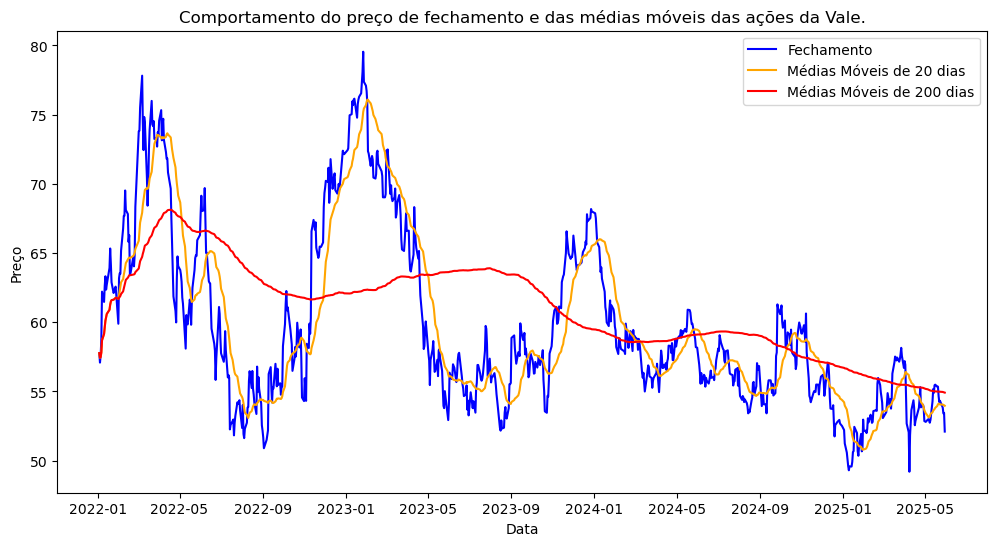

In [ ]:
# Vamos visualizar o comportamento de fechamento e médias móveis das ações da VALE:

plt.figure(figsize=(12,6))
plt.plot(df['Close_VALE3'], label='Fechamento', color='blue')
plt.plot(df['MM_20D_VALE3'], label='Médias Móveis de 20 dias', color='orange')
plt.plot(df['MM_200D_VALE3'], label='Médias Móveis de 200 dias', color='red')
plt.title('Comportamento do preço de fechamento e das médias móveis das ações da Vale.')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.legend()
plt.show()

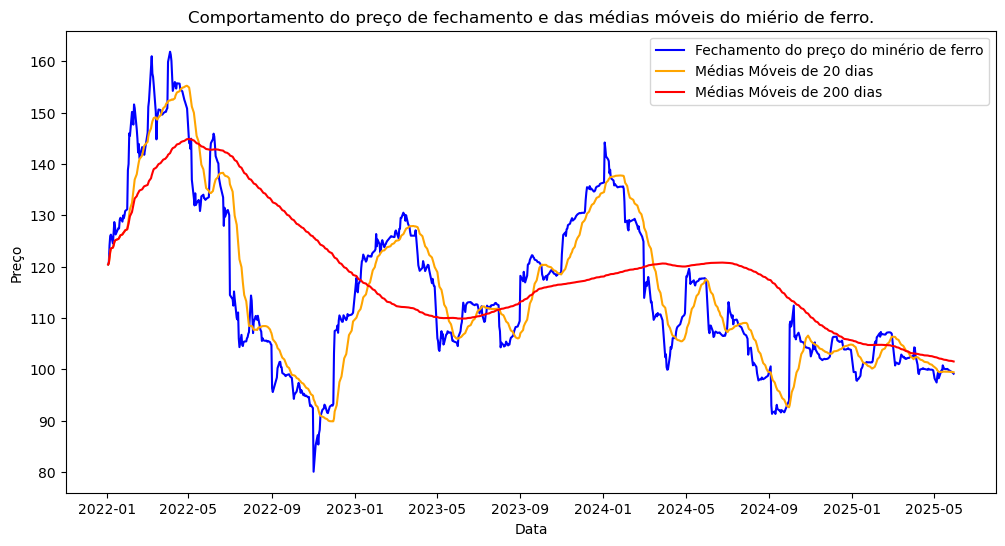

In [7]:
# Vamos visualizar o comportamento de abertura, fechamento e médias móveis das ações do minério de ferro:

plt.figure(figsize=(12,6))
plt.plot(df['Close_Minerio'], label='Fechamento do preço do minério de ferro', color='blue')
plt.plot(df['MM_20D_MF'], label='Médias Móveis de 20 dias', color='orange')
plt.plot(df['MM_200D_MF'], label='Médias Móveis de 200 dias', color='red')
plt.title('Comportamento do preço de fechamento e das médias móveis do miério de ferro.')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.legend()
plt.show()

# 3. Decomposição da Serie Temporal.

In [8]:
decomposicao = seasonal_decompose(df['Close_VALE3'], model='multiplicative', period=30)
df['Tendencia'] = decomposicao.trend
df['Sazonalidade'] = decomposicao.seasonal
df['Residuo'] = decomposicao.resid

# Preencher valores ausentes resultantes da decomposição:
df.fillna(method='bfill', inplace=True)
df.fillna(method='ffill', inplace=True)

# 4. Lags e Rolling Statistics.

* Vamos criar colunas que trazem o preço de fechamento e o retorno percentual de ontem, anteontem, etc. Assim o modelo “vê” vários dias anteriores:

In [9]:
lags = [1, 2, 3, 4, 5] # dias de atraso

for lag in lags:
    df[f'Close_Vale_lag{lag}'] = df['Close_VALE3'].shift(lag) # Preço do fechamento lagado
    df[f'Ret_Vale_lag{lag}'] = df['Close_VALE3'].shift(lag) # Retorno percentual lagado

* Agora, para captar tendências e volatilidade de curto e médio prazo, vamos criar médias móveis de curto prazo e estatísticas móveis (desvio, assimetria, curtose) em janelas de vários tamanhos:

In [ ]:
windows = [5, 10, 15, 30, 50] # Janelas de dias

for w in windows:
    # Média móvel
    df[f'MM_de_{w}'] = df['Close_VALE3'].rolling(window=w, min_periods=1).mean()
    # Desvio-padrão móvel dos retornos em w dias
    df[f'Desvio_Padrao_de_{w}'] = df['Close_VALE3'].rolling(window=w).std()
    # Assimetria móvel dos retornos
    df[f'roll_skew_{w}'] = df['Close_VALE3'].rolling(window=w).skew()
    # Curtose móvel dos retornos
    df[f'Curtose_{w}'] = df['Close_VALE3'].rolling(window=w).kurt()
df

,Close_VALE3,Open_VALE3,Volume_VALE3,Close_Minerio,Open_Minerio,Variação_Minerio,Variação_VALE3,Dia,Semana,Mês,...,roll_skew_15,Curtose_15,MM_de_30,Desvio_Padrao_de_30,roll_skew_30,Curtose_30,MM_de_50,Desvio_Padrao_de_50,roll_skew_50,Curtose_50
2022-01-03,57.766407,58.507002,18557200,120.40,120.40,7.020000,0.000000,3,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-04,57.085068,58.144119,18178700,120.91,120.91,0.423588,-1.179473,4,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-05,57.625698,57.299840,22039000,124.14,124.14,2.671408,0.947061,5,2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-06,58.788429,58.240391,22044100,125.94,125.94,1.449976,2.017730,6,3,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-07,62.209988,59.543846,35213100,126.21,126.21,0.214388,5.820122,7,4,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-23,54.320000,54.000000,14747300,99.81,99.81,-0.080088,0.165960,23,4,5,...,-0.324580,-1.637176,53.886667,1.031050,0.026033,-1.077892,54.7078,1.957700,-0.092500,-0.233223
2025-05-27,53.840000,54.000000,17943000,99.48,99.48,-0.330628,-0.883652,27,1,5,...,-0.414413,-1.341707,53.953000,0.956845,0.165655,-1.250139,54.7094,1.956942,-0.094601,-0.228681
2025-05-28,53.410000,53.740002,17700600,99.39,99.39,-0.090470,-0.798663,28,2,5,...,-0.421093,-1.216086,53.974000,0.936919,0.169704,-1.187451,54.6876,1.965375,-0.064842,-0.278782
2025-05-29,53.450001,53.730000,10246100,99.27,99.27,-0.120736,0.074894,29,3,5,...,-0.394918,-1.104977,53.967000,0.940125,0.186887,-1.207078,54.6308,1.959149,0.008174,-0.252883


In [11]:
df = df.dropna()
df

,Close_VALE3,Open_VALE3,Volume_VALE3,Close_Minerio,Open_Minerio,Variação_Minerio,Variação_VALE3,Dia,Semana,Mês,...,roll_skew_15,Curtose_15,MM_de_30,Desvio_Padrao_de_30,roll_skew_30,Curtose_30,MM_de_50,Desvio_Padrao_de_50,roll_skew_50,Curtose_50
2022-03-17,72.523079,71.446383,40663500,149.65,149.65,0.537454,3.478544,17,3,3,...,-0.652900,-0.254251,68.751516,4.330053,0.426402,-1.012722,65.922057,5.035079,0.547484,-0.353330
2022-03-18,73.899719,73.376759,46080900,150.59,150.59,0.628132,1.898210,18,4,3,...,-0.743465,0.405947,69.108835,4.296611,0.312595,-1.142488,66.244723,5.018683,0.528286,-0.505108
2022-03-21,75.991570,74.853353,25374600,150.47,150.47,-0.079687,2.830661,21,0,3,...,-0.429446,-0.422592,69.524032,4.341083,0.220117,-1.242552,66.622853,5.026713,0.573832,-0.676256
2022-03-22,74.291939,75.760861,29489800,149.68,149.68,-0.525022,-2.236604,22,1,3,...,-0.559941,0.382497,69.883563,4.271573,0.114531,-1.300736,66.956178,4.970187,0.587939,-0.878414
2022-03-23,74.176582,74.984106,26309600,149.57,149.57,-0.073490,-0.155275,23,2,3,...,-0.590661,0.379886,70.183703,4.245386,-0.022278,-1.299687,67.263941,4.930376,0.570389,-1.051368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-23,54.320000,54.000000,14747300,99.81,99.81,-0.080088,0.165960,23,4,5,...,-0.324580,-1.637176,53.886667,1.031050,0.026033,-1.077892,54.707800,1.957700,-0.092500,-0.233223
2025-05-27,53.840000,54.000000,17943000,99.48,99.48,-0.330628,-0.883652,27,1,5,...,-0.414413,-1.341707,53.953000,0.956845,0.165655,-1.250139,54.709400,1.956942,-0.094601,-0.228681
2025-05-28,53.410000,53.740002,17700600,99.39,99.39,-0.090470,-0.798663,28,2,5,...,-0.421093,-1.216086,53.974000,0.936919,0.169704,-1.187451,54.687600,1.965375,-0.064842,-0.278782
2025-05-29,53.450001,53.730000,10246100,99.27,99.27,-0.120736,0.074894,29,3,5,...,-0.394918,-1.104977,53.967000,0.940125,0.186887,-1.207078,54.630800,1.959149,0.008174,-0.252883
